INSTALLING LIBRARIES

In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gpytorch torch

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pykeops

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import torch
import gpytorch
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

DATA PREPROCESSING

In [7]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

def preprocess_data(df, scaler=None, train=True, factor=1.5):
    """
    Preprocess dataset:
    - Creates 'Moneyness' & 'IV' features
    - Computes 'log_IV' and clips to [-10, 10]
    - Handles missing values & removes outliers (only in training)
    - Standardizes 'Moneyness' & 'time_to_maturity_days' only

    Parameters:
    - df: Input DataFrame
    - scaler: Pre-fitted StandardScaler for test data (None for training)
    - train: Boolean, whether processing training or test data
    - factor: Float, controls how strict IQR method is for outlier removal

    Returns:
    - Processed DataFrame
    - Scaler (only in training mode)
    """
    df = df.copy()  

    # Feature Engineering
    df["Moneyness"] = df["underlying_last"] / df["strike"]
    df["IV"] = df[["c_iv", "p_iv"]].mean(axis=1)
    df["log_IV"] = np.log(df["IV"])
    df["log_IV"] = np.clip(df["log_IV"], -10, 10)
    
    # Handle infinities
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Remove missing values
    df.dropna(inplace=True)
    
    # Remove outliers (only in training data)
    if train:
        for col in ["c_iv", "p_iv"]:
            if col in df.columns:
                Q1, Q3 = df[col].quantile([0.25, 0.75])
                IQR = Q3 - Q1
                lower_bound = Q1 - factor * IQR
                upper_bound = Q3 + factor * IQR
                df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    # Selecting numeric columns
    numeric_cols = ["Moneyness", "time_to_maturity_days"]
    
    # Standardizing only Moneyness & Time to Maturity
    if train:
        scaler = StandardScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
        return df, scaler  # ✅ Return both df and scaler in training mode
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided for test data processing")
        df[numeric_cols] = scaler.transform(df[numeric_cols])
        return df  # ✅ Return only df in test mode


In [8]:
df = pd.read_csv("Options_Data_SPX_Filtered_3years.csv")
df_train, scaler = preprocess_data(df, train=True)


In [9]:
df_train.shape

(980749, 37)

Volatility Smile

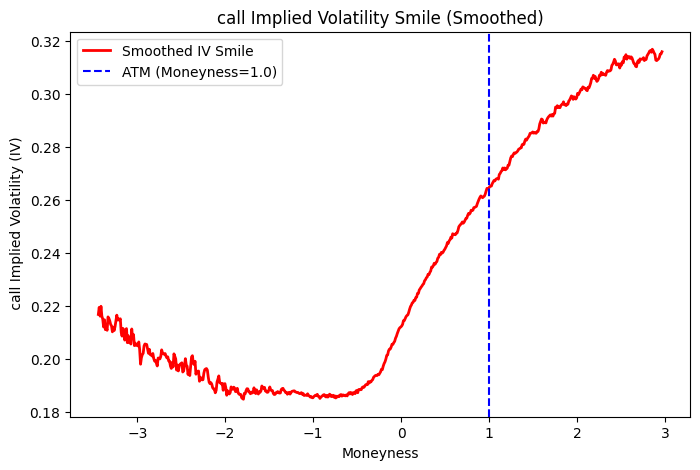

In [10]:
#Call option Smile
moneyness = df_train["Moneyness"].values
iv_data = df_train["c_iv"].values  

valid_indices = np.isfinite(moneyness) & np.isfinite(iv_data) & (iv_data > 0.01)
moneyness = moneyness[valid_indices]
iv_data = iv_data[valid_indices]

# Sort by Moneyness
sorted_indices = np.argsort(moneyness)
moneyness = moneyness[sorted_indices]
iv_data = iv_data[sorted_indices]

# Bin Data to Reduce Noise
bin_width = 0.01  
bins = np.arange(moneyness.min(), moneyness.max(), bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2  
iv_binned = [iv_data[(moneyness >= bins[i]) & (moneyness < bins[i+1])].mean() for i in range(len(bins)-1)]

bin_centers = bin_centers[~np.isnan(iv_binned)]
iv_binned = np.array(iv_binned)[~np.isnan(iv_binned)]

#  Apply a Moving Average to Smooth Further
window_size = 5
iv_smoothed = np.convolve(iv_binned, np.ones(window_size)/window_size, mode='valid')

#Plot the Smile
plt.figure(figsize=(8, 5))
plt.plot(bin_centers[:len(iv_smoothed)], iv_smoothed, color='red', linewidth=2, label="Smoothed IV Smile") 
plt.axvline(1.0, color='blue', linestyle="--", label="ATM (Moneyness=1.0)") 
plt.xlabel("Moneyness")
plt.ylabel(" call Implied Volatility (IV)")
plt.title("call Implied Volatility Smile (Smoothed)")
plt.legend()
plt.show()

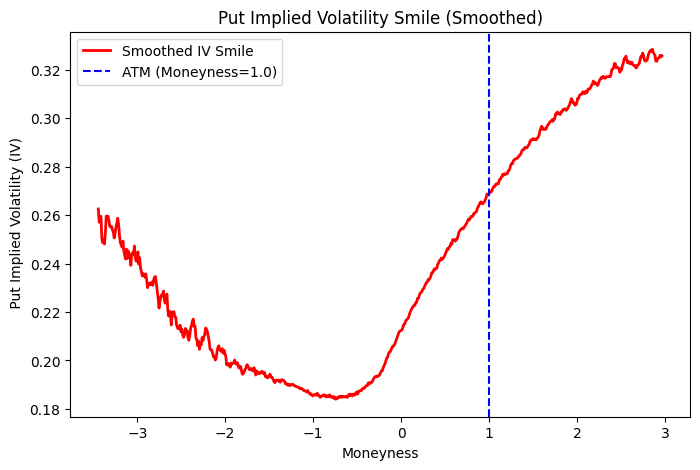

In [11]:
# Put option Smile
Moneyness = df_train["Moneyness"].values
iv_data = df_train["p_iv"].values  

valid_indices = np.isfinite(Moneyness) & np.isfinite(iv_data) & (iv_data > 0.01)
Moneyness = Moneyness[valid_indices]
iv_data = iv_data[valid_indices]

# Sort by Moneyness
sorted_indices = np.argsort(Moneyness)
Moneyness = Moneyness[sorted_indices]
iv_data = iv_data[sorted_indices]

# Bin Data to Reduce Noise
bin_width = 0.01  
bins = np.arange(Moneyness.min(), Moneyness.max(), bin_width)
bin_centers = (bins[:-1] + bins[1:]) / 2  
iv_binned = [iv_data[(Moneyness >= bins[i]) & (Moneyness < bins[i+1])].mean() for i in range(len(bins)-1)]

bin_centers = bin_centers[~np.isnan(iv_binned)]
iv_binned = np.array(iv_binned)[~np.isnan(iv_binned)]

#  Apply a Moving Average to Smooth Further
window_size = 5
iv_smoothed = np.convolve(iv_binned, np.ones(window_size)/window_size, mode='valid')

#Plot the Smile
plt.figure(figsize=(8, 5))
plt.plot(bin_centers[:len(iv_smoothed)], iv_smoothed, color='red', linewidth=2, label="Smoothed IV Smile") 
plt.axvline(1.0, color='blue', linestyle="--", label="ATM (Moneyness=1.0)") 
plt.xlabel("Moneyness")
plt.ylabel(" Put Implied Volatility (IV)")
plt.title("Put Implied Volatility Smile (Smoothed)")
plt.legend()
plt.show()

MODELLING

In [12]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [15]:
selected_features = ["Moneyness", "time_to_maturity_days"]
X = df_train[selected_features].values
y = df_train["log_IV"].values

# Split Data into Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float64)
y_train_torch = torch.tensor(y_train, dtype=torch.float64)
X_val_torch = torch.tensor(X_val, dtype=torch.float64)
y_val_torch = torch.tensor(y_val, dtype=torch.float64)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_torch = X_train_torch.to(device, non_blocking=True)
y_train_torch = y_train_torch.to(device, non_blocking=True)
X_val_torch = X_val_torch.to(device, non_blocking=True)
y_val_torch = y_val_torch.to(device, non_blocking=True)


# Inducing Points
num_inducing = min(500, len(X_train))  
random_indices = torch.randperm(len(X_train))[:num_inducing] 
inducing_points = X_train_torch[random_indices].clone()

# Define the Sparse GP Model
class SVGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()

        # Use RBF Kernel with Separate Lengthscales for Moneyness and Time to Maturity
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2, lengthscale_constraint=gpytorch.constraints.Positive())
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x).add_jitter(1e-3) 
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Initialize model and likelihood
model = SVGPModel(inducing_points).to(device).double()
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device).double()

# DEfining Batch Size 
batch_size = 2048
train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Use AdamW Optimizer 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=1e-4) 

# Cosine Annealing Scheduler for Smoother LR Decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-4)

# Define ELBO Loss Function
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=X_train_torch.size(0))

# Enable GPU Optimization
torch.backends.cudnn.benchmark = True

# Training loop
model.train()
likelihood.train()
num_epochs = 20  

for epoch in range(1, num_epochs + 1):  # Start epochs from 1 for readability
    train_loss = 0.0
    num_batches = len(train_loader)

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Compute Average Training Loss
    avg_train_loss = train_loss / num_batches

    # Compute Validation Loss
    model.eval()
    with torch.no_grad():
        val_output = model(X_val_torch)
        val_loss = -mll(val_output, y_val_torch).item()
    model.train()

    # Reduce Learning Rate
    scheduler.step()

    # Print loss values
    print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {avg_train_loss:.6f} - Val Loss: {val_loss:.6f}")

print("✅ Training Completed Successfully!")

# Save the trained model
torch.save(model.state_dict(), "gp_model.pth")
print("✅ Model saved successfully!")

Epoch [1/20] - Train Loss: 0.989656 - Val Loss: 0.774949
Epoch [2/20] - Train Loss: 0.771803 - Val Loss: 0.769972
Epoch [3/20] - Train Loss: 0.769295 - Val Loss: 0.768848
Epoch [4/20] - Train Loss: 0.768494 - Val Loss: 0.768231
Epoch [5/20] - Train Loss: 0.768113 - Val Loss: 0.767941
Epoch [6/20] - Train Loss: 0.767947 - Val Loss: 0.767848
Epoch [7/20] - Train Loss: 0.767818 - Val Loss: 0.767852
Epoch [8/20] - Train Loss: 0.767730 - Val Loss: 0.767663
Epoch [9/20] - Train Loss: 0.767671 - Val Loss: 0.767563
Epoch [10/20] - Train Loss: 0.767606 - Val Loss: 0.767625
Epoch [11/20] - Train Loss: 0.767574 - Val Loss: 0.767520
Epoch [12/20] - Train Loss: 0.767549 - Val Loss: 0.767511
Epoch [13/20] - Train Loss: 0.767514 - Val Loss: 0.767532
Epoch [14/20] - Train Loss: 0.767505 - Val Loss: 0.767517
Epoch [15/20] - Train Loss: 0.767469 - Val Loss: 0.767387
Epoch [16/20] - Train Loss: 0.767445 - Val Loss: 0.767388
Epoch [17/20] - Train Loss: 0.767439 - Val Loss: 0.767370
Epoch [18/20] - Train L

TESTING

In [17]:
# Load the scaler
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

# Load new test data and preprocess it
df_test = pd.read_csv("SPX_TEST_JAN.csv")
df_preprocessed_test = preprocess_data(df_test, scaler=scaler, train=False)
y_test = df_preprocessed_test["log_IV"].values 
# Convert to tensor
X_test = torch.tensor(df_preprocessed_test[selected_features].values, dtype=torch.float64).to(device)

# Reload Model
model = SVGPModel(inducing_points).to(device).double()
model.load_state_dict(torch.load("gp_model.pth", map_location=device))
model.eval()

# Make predictions
with torch.no_grad():
    preds = model(X_test)

print("✅ Predictions done!")
 
# Extract Mean Predictions
y_pred_mean = preds.mean.cpu().numpy()

# Convert Back from Log-Scale 
y_pred_actual = np.exp(y_pred_mean)  
y_test_actual = np.exp(y_test)  

# Compute Performance Metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

#  Print Performance Metrics
print(f"✅ Model Performance:")
print(f"📌 Mean Squared Error (MSE): {mse:.4f}")
print(f"📌 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📌 Mean Absolute Error (MAE): {mae:.4f}")


✅ Predictions done!
✅ Model Performance:
📌 Mean Squared Error (MSE): 0.0611
📌 Root Mean Squared Error (RMSE): 0.2473
📌 Mean Absolute Error (MAE): 0.0615


VOLATILITY SURFACE

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


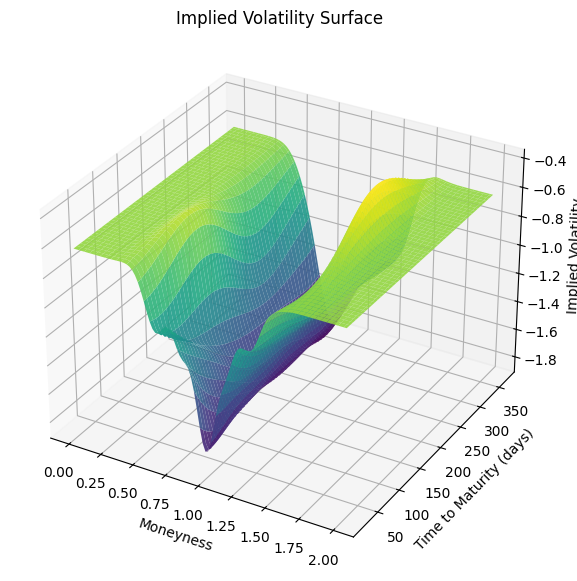

In [18]:
# ✅ Define Moneyness and Time to Maturity Ranges
moneyness_range = np.linspace(0, 2, 100)  # From Deep ITM to Deep OTM
time_to_maturity_range = np.linspace(20, 365, 100)  # 20 to 300 days

# Create Grid
M, T = np.meshgrid(moneyness_range, time_to_maturity_range)
X_grid = np.vstack([M.ravel(), T.ravel()]).T

# Standardize Features (Same scaler as training)
X_grid_scaled = scaler.transform(X_grid)

# Convert to PyTorch Tensor and Move to GPU
X_grid_torch = torch.tensor(X_grid_scaled, dtype=torch.float64).to(device)

# Get GP Predictions
model.eval()
likelihood.eval()
with torch.no_grad():
    pred = model(X_grid_torch)
    mean = pred.mean.cpu().numpy()
    std = pred.stddev.cpu().numpy()

# Reshape for Surface Plot
mean_surface = mean.reshape(M.shape)
std_surface = std.reshape(M.shape)

# Plot 3D Implied Volatility Surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(M, T, mean_surface, cmap='viridis', alpha=0.9)
ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity (days)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface')

plt.show()
